## Automatic Classification of Software Artifacts in Open-Source Applications
**Approaches:**  
Nest CV  
Conventional ML using TF-IDF;  
RNN with the use of GloVe;  
Traditional ML with the use of GloVe.

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install silence_tensorflow
!pip install pycm
!pip install lime
!pip install transformers
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.1.1-cp37-none-any.whl size=3743 sha256=f7c28f0e467d54565d717485be82a6b6e43e80498cc9d7e148776fc6bc2287bb
  Stored in directory: /root/.cache/pip/wheels/51/0b/35/cf3020764bee61daa81fa249df3a448e3806344a087fc12292
Successfully built silence-tensorflow
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 573kB 25.4MB/s 
     |████████████████████████████████| 276kB 18.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=61d1626bf1820b2df4a9261a007e7ad442f7588e99974f89ab22515b1d1680cb
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 2.1MB 18.5MB/s 
     |████████████████████████████████| 3.3MB 54.9MB/s 
     |████████████████████████████████| 901kB 51.0MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[n

True

In [4]:
import os
default_path = "/content/gdrive/MyDrive/Colab Notebooks/Automatic Software Artifacts"
os.chdir(default_path)

In [5]:
import warnings
import numpy as np
import pandas as pd
import tensorflow
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D, LSTM, SpatialDropout1D, Input, Flatten, MaxPooling1D
from sklearn.utils import shuffle
from tensorflow.keras.layers import Embedding
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
# for processing
import nltk
import re
# for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
# Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc
# from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc, accuracy_score

from pycm import *
# for explainer
from lime import lime_text
# for word embedding
import gensim
import gensim.downloader as gensim_api
# for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
# for bert language model
# import transformers
# Classifiers

# For GloVe
import os
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB

from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import utils

import matplotlib as mpl
# Set the default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["b", "k", "c"]) 

import utils_functions as uf

%matplotlib inline
np.random.seed(7)

warnings.filterwarnings("ignore")

In [6]:
# Global parameters
#root folder
root_folder='.'
data_folder_name='data'
glove_filename='glove.42B.300d.txt'

train_filename='train.csv'
# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
glove_path = os.path.abspath(os.path.join(DATA_PATH, glove_filename))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

#Relevant columns
TEXT_COLUMN = 'text'
TARGET_COLUMN = 'target'

### Read and Show a Data Sample

In [7]:
file = 'aug_original_dataset.csv'
df = pd.read_csv(file,encoding='ISO-8859-1')

In [8]:
df.sample(5)

,Label,Text
96,License,copyright c puppet labs inc and some parts cop...
22,List of Contributors,this is at least a partial credits file of peo...
113,License,gnu general public license version june copyri...
138,Contributors' Guide,testing with selenium selenium docs seleniumhq...
253,Setup Files,changes cz pm examples pl examples pl inc modu...


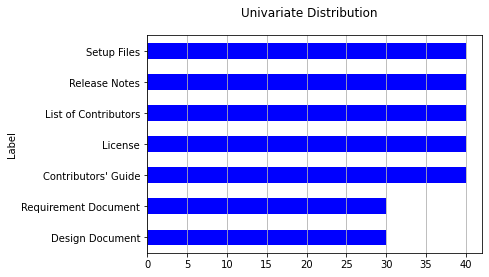

In [9]:
fig, ax = plt.subplots()
fig.suptitle("Univariate Distribution", fontsize=12)
df["Label"].reset_index().groupby("Label").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

### Feature Engineering - Tf-Idf (advanced variant of BoW)

In [ ]:
# Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

### Create the feature matrix

Text(0.5, 1.0, 'Sparse Matrix Sample')

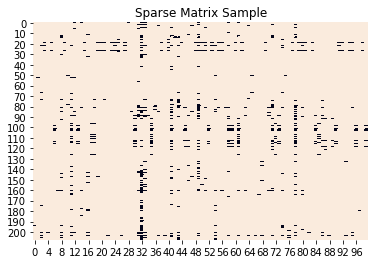

In [ ]:
corpus = df["Text"]
vectorizer.fit(corpus)
X = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

sns.heatmap(X.todense()[:,np.random.randint(0,X.shape[1],100)]==0, vmin=0, vmax=1,
            cbar=False).set_title('Sparse Matrix Sample')

In [ ]:
# The position of a certain word (example)
word = "java"
dic_vocabulary[word]

4459

### Feature Selection
In order to drop some columns and reduce the matrix dimensionality:
  1. Treat each category as binary (for example, the “Design Document” category is 1 and 0 for the others);  
  2. Perform a Chi-Square test to determine whether a feature and the (binary) target are independent;  
  3. keep only the features with a certain p-value from the Chi-Square test.

In [ ]:
y = df["Label"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.90
df_features = pd.DataFrame()
print("Initial dimension", len(X_names))
# perform a Chi-Square test to determine whether a feature and the (binary) target are independent
# keep only the features with a certain p-value from the Chi-Square test.
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X, y==cat)
    df_features = df_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "Label":cat}))
    df_features = df_features.sort_values(["Label","score"], 
                    ascending=[True,False])
    df_features = df_features[df_features["score"]>p_value_limit]
X_names = df_features["feature"].unique().tolist()
print("Final dimension", len(X_names))

Initial dimension 10000
Final dimension 354


### Selected Features Sample

In [ ]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(df_features[df_features["Label"]==cat]))
   print("  . top features:", ",".join(
df_features[df_features["Label"]==cat]["feature"].values[:10]))
   print(" ")

# Contributors' Guide:
  . selected features: 25
  . top features: pull request,pull,request,test,issu,mechan,selenium,plea,fork,cla
 
# Design Document:
  . selected features: 47
  . top features: design pattern,counter,messageloggerq,messageloggerscrib,item,breakpoint,observ,autoexcept,pattern,messagesend
 
# License:
  . selected features: 174
  . top features: softwar,licens,copyright,copi,warranti,shall,distribut,notic,permiss,deal softwar
 
# List of Contributors:
  . selected features: 39
  . top features: martin,origin author,driver,com,gmail,gmail com,net,de,maintain,chri
 
# Release Notes:
  . selected features: 19
  . top features: fix,ad,gitx,updat,view,commit view,add,chang,chang ad,johann
 
# Requirement Document:
  . selected features: 28
  . top features: mount,marker,block,speakup,uml,column,world,codec,filesystem,audio
 
# Setup Files:
  . selected features: 22
  . top features: grunt,docker,mock,url http,person cz,grunt contrib,cz,contrib,mock person,nova
 


### Refit and Reduce Dimensionality

Text(0.5, 1.0, 'Sparse Matrix Sample')

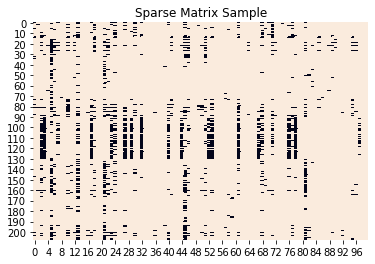

In [ ]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

sns.heatmap(X.todense()[:,np.random.randint(0,X.shape[1],100)]==0,
            vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

### Classifier

In [10]:
# Model Design
clf1 = svm.SVC(gamma='scale')
clf2 = RandomForestClassifier(n_estimators=500, random_state=1)
clf3 = MultinomialNB(alpha=0.01)
clf4 = DecisionTreeClassifier(random_state=0, max_depth=500)

svc = SVC(probability=True, kernel='linear')
ada = AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)
ada2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")
ada3 = AdaBoostClassifier()
rf = RandomForestClassifier(max_depth=100, n_estimators=100, max_features=10)
# nb = naive_bayes.MultinomialNB(alpha=0.01)
nb = naive_bayes.MultinomialNB(alpha=0.0)
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', class_weight='balanced', C=1500)
dt = DecisionTreeClassifier(max_depth=500)

In [ ]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    preds = []
    # conf_matrix_list_of_arrays = []
    k = 10
    fold = 0
    
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=0)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        fold += 1

        # train classifier
        model = rf.fit(X_train, y_train)
        predicted = model.predict(X_test)
        predicted_prob = model.predict_proba(X_test)
        accr = metrics.accuracy_score(y_test, predicted)

        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
    #  
        accrs.append(accr)
        preds.append(predicted)

        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    print("-------------------------------------------")
    final_mean.append(sum(accrs)/k)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

Iteração: 1 Fold: 1 Accuracy: 0.7380952380952381, Mean Accuracy: 0.7380952380952381
Iteração: 1 Fold: 2 Accuracy: 0.7619047619047619, Mean Accuracy: 0.75
Iteração: 1 Fold: 3 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7380952380952381
Iteração: 1 Fold: 4 Accuracy: 0.8095238095238095, Mean Accuracy: 0.7559523809523809
Iteração: 1 Fold: 5 Accuracy: 0.8809523809523809, Mean Accuracy: 0.780952380952381
Iteração: 1 Fold: 6 Accuracy: 0.6904761904761905, Mean Accuracy: 0.7658730158730158
Iteração: 1 Fold: 7 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7687074829931972
Iteração: 1 Fold: 8 Accuracy: 0.7380952380952381, Mean Accuracy: 0.7648809523809523
Iteração: 1 Fold: 9 Accuracy: 0.7380952380952381, Mean Accuracy: 0.7619047619047619
Iteração: 1 Fold: 10 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7571428571428571
-------------------------------------------
Iteração: 2 Fold: 1 Accuracy: 0.6666666666666666, Mean Accuracy: 0.6666666666666666
Iteração: 2 Fold: 2 Accuracy: 0.78571428571428

Iteração: 10 Fold: 5 Accuracy: 0.8095238095238095, Mean Accuracy: 0.7666666666666666
Iteração: 10 Fold: 6 Accuracy: 0.6666666666666666, Mean Accuracy: 0.75
Iteração: 10 Fold: 7 Accuracy: 0.7380952380952381, Mean Accuracy: 0.7482993197278912
Iteração: 10 Fold: 8 Accuracy: 0.7619047619047619, Mean Accuracy: 0.75
Iteração: 10 Fold: 9 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7513227513227513
Iteração: 10 Fold: 10 Accuracy: 0.6904761904761905, Mean Accuracy: 0.7452380952380953
-------------------------------------------


In [ ]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.7461904761904762


### Evaluate

#### Plot metrics resume and Confusion Matrix

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Contributors' Guide 	      0.86	      0.86	      0.86	      0.83	      0.91
Design Document     	       1.0	      0.33	       0.5	      0.56	      0.67
License             	       1.0	       1.0	       1.0	       1.0	       1.0
List of Contributors	       1.0	       0.6	      0.75	      0.75	       0.8
Release Notes       	      0.88	       1.0	      0.93	      0.92	      0.98
Requirement Document	       1.0	      0.33	       0.5	      0.56	      0.67
Setup Files         	      0.55	       1.0	      0.71	      0.68	      0.92

Macro Average       	       0.9	      0.73	      0.75	      0.76	      0.85
Micro Average       	      0.82	      0.82	      0.82	      0.68	      0.89


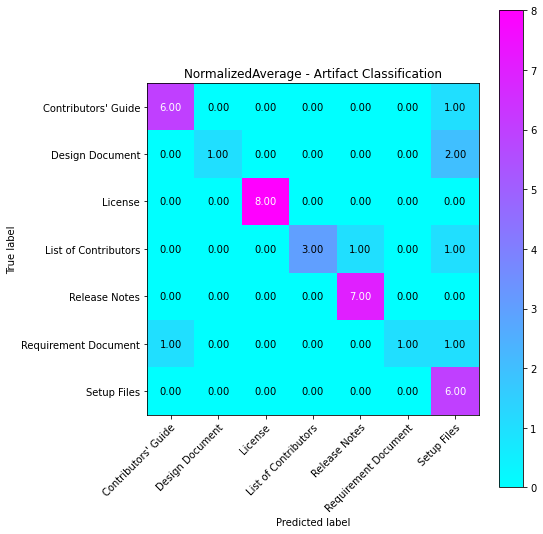

In [ ]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

### Voting Classifier

In [ ]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    preds = []
    # conf_matrix_list_of_arrays = []
    k = 10
    fold = 0
    
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=0)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        fold += 1

        # train classifier
        model = VotingClassifier(estimators=[
        ('svm', clf1),('rf', clf2), ('mnb', clf3), ('tree', clf4)], voting='hard',weights=[1,1,2,1])
        model = model.fit(X_train, y_train)
        
        predicted = model.predict(X_test)
        accr = metrics.accuracy_score(y_test, predicted)

        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
    #  
        accrs.append(accr)
        preds.append(predicted)

        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    print("-------------------------------------------")
    final_mean.append(sum(accrs)/k)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

Iteração: 1 Fold: 1 Accuracy: 0.8095238095238095, Mean Accuracy: 0.8095238095238095
Iteração: 1 Fold: 2 Accuracy: 0.8095238095238095, Mean Accuracy: 0.8095238095238095
Iteração: 1 Fold: 3 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7936507936507936
Iteração: 1 Fold: 4 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7916666666666666
Iteração: 1 Fold: 5 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7857142857142857
Iteração: 1 Fold: 6 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7738095238095237
Iteração: 1 Fold: 7 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7755102040816325
Iteração: 1 Fold: 8 Accuracy: 0.8571428571428571, Mean Accuracy: 0.7857142857142856
Iteração: 1 Fold: 9 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142856
Iteração: 1 Fold: 10 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142856
-------------------------------------------
Iteração: 2 Fold: 1 Accuracy: 0.8095238095238095, Mean Accuracy: 0.8095238095238095
Iteração: 2 Fold: 2 Accuracy: 0

Iteração: 10 Fold: 4 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7916666666666666
Iteração: 10 Fold: 5 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7857142857142857
Iteração: 10 Fold: 6 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7738095238095237
Iteração: 10 Fold: 7 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7755102040816325
Iteração: 10 Fold: 8 Accuracy: 0.8571428571428571, Mean Accuracy: 0.7857142857142856
Iteração: 10 Fold: 9 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142856
Iteração: 10 Fold: 10 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142856
-------------------------------------------


In [ ]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.7857142857142856


### Evaluate

#### Plot metrics resume and Confusion Matrix

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Contributors' Guide 	      0.78	       1.0	      0.88	      0.85	      0.97
Design Document     	       1.0	      0.33	       0.5	      0.56	      0.67
License             	       1.0	       1.0	       1.0	       1.0	       1.0
List of Contributors	       1.0	       1.0	       1.0	       1.0	       1.0
Release Notes       	       1.0	      0.88	      0.93	      0.92	      0.94
Requirement Document	       0.5	       0.5	       0.5	      0.47	      0.74
Setup Files         	      0.71	      0.83	      0.77	      0.73	      0.89

Macro Average       	      0.86	      0.79	       0.8	      0.79	      0.88
Micro Average       	      0.87	      0.87	      0.87	      0.73	      0.92


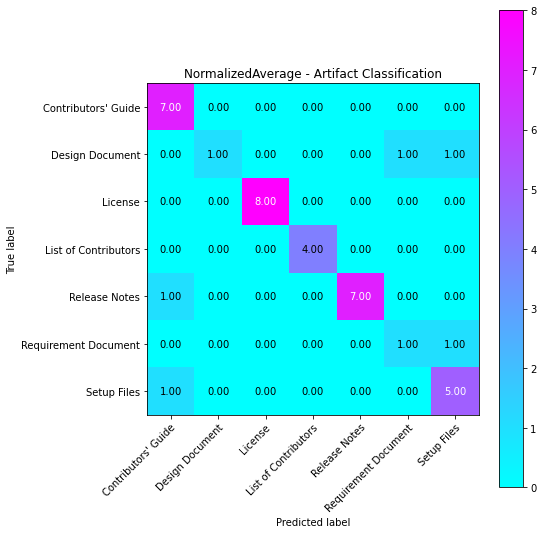

In [ ]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

## GloVe

### Loading the model (glove.42B.300d)
The GloVe 42B.300d, is a Common Crawl (42B tokens, 1.9M vocab, uncased, 300d vectors, 1.75 GB download).

In [11]:
# We just need to run this code once, the function glove2word2vec saves the Glove embeddings in the word2vec format 
# that will be loaded in the next section
from gensim.scripts.glove2word2vec import glove2word2vec

word2vec_output_file = glove_filename+'.word2vec'
# glove2word2vec(glove_path, word2vec_output_file)

In [12]:
# load the Stanford GloVe model
from gensim.models import KeyedVectors
word2vec_output_file = glove_filename+'.word2vec'
word_vect = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
#Show a word embedding
print('King: ',word_vect.get_vector('king'))

result = word_vect.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

print('Most similar word to King + Woman: ', result)

King:  [-2.7381e-01  2.6752e-01  1.1490e-02 -1.5876e-01 -6.8417e-02  6.1086e-01
 -1.7651e+00 -5.5161e-01 -5.7723e-01 -2.7816e-02  4.5391e-03  4.2403e-01
  7.6693e-03  4.1675e-01  1.5134e-01 -1.1986e-01 -5.7090e-01 -7.6831e-01
  4.3965e-02  2.2138e-01  5.0782e-01  8.0745e-02  1.0530e-01 -1.5478e-01
  3.0112e-01 -5.0475e-01 -4.1413e-01  4.7806e-01  1.4708e-01  3.7711e-02
  1.2259e-02 -5.8732e-01 -1.7254e-01 -4.8854e-01  2.0883e-01 -2.3158e-01
  4.0798e-03  7.8209e-02 -1.2726e-01  1.6076e-03  1.1017e-01  7.3764e-01
 -3.6646e-01 -3.3482e-01  1.7398e-01 -1.6575e-01 -7.5085e-02 -1.4085e-01
  2.5734e-01  6.4029e-01  6.3846e-01  5.9132e-02 -1.7128e-01  3.9512e-01
  2.9804e-01  3.7342e-02 -4.1155e-01  2.0047e-01 -3.9340e-01 -2.9488e-01
  1.1896e-01  2.6823e-01  5.1301e-01 -3.8040e-01 -1.9490e-01  2.9677e-02
  1.7390e-01 -3.5106e-02 -1.5921e-02 -1.3907e-01 -4.3194e-01  1.5473e-02
 -2.7858e-01  2.1920e-01  2.0801e-01 -5.9925e-02  1.1125e-04 -4.3176e-01
  1.4686e-01  4.8844e-01  6.0544e-02 -4.6726

In [13]:
# total words in vocab
vocab_obj = word_vect.vocab["word"]
vocab_obj.count

1916801

In [ ]:
# top 20 most similar words
word_vect.most_similar(word, topn=20)

[('c++', 0.687698245048523),
 ('j2ee', 0.6488214731216431),
 ('javascript', 0.6401231288909912),
 ('xml', 0.6021153926849365),
 ('php', 0.5984039306640625),
 ('perl', 0.5907211303710938),
 ('api', 0.588263750076294),
 ('python', 0.5860908031463623),
 ('programming', 0.5810009837150574),
 ('jsp', 0.579157829284668),
 ('developer', 0.5787414908409119),
 ('oracle', 0.5719089508056641),
 ('sql', 0.5692706108093262),
 ('applet', 0.555595874786377),
 ('linux', 0.5553056597709656),
 ('j2me', 0.552773118019104),
 ('gui', 0.5500690937042236),
 ('mysql', 0.5494028329849243),
 ('scripting', 0.5474516153335571),
 ('html', 0.5473135709762573)]

#### A Word and its Context (3D)

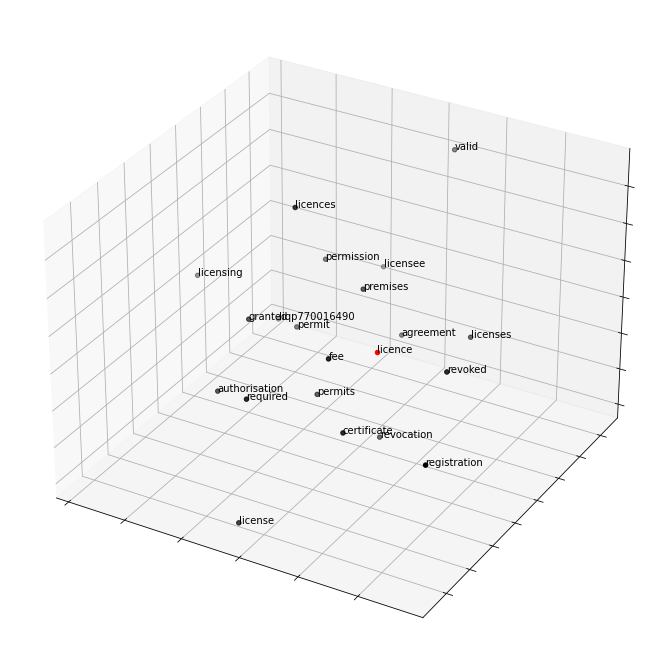

In [ ]:
word = "licence"
fig = plt.figure(figsize=(15,12))
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 word_vect.most_similar(word, topn=20)]
X = word_vect[tot_words]
## pca to reduce dimensionality from 100 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dataframe
dt_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dt_["input"] = 0
dt_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dt_[dt_["input"]==0]['x'], 
           dt_[dt_["input"]==0]['y'], 
           dt_[dt_["input"]==0]['z'], c="black")
ax.scatter(dt_[dt_["input"]==1]['x'], 
           dt_[dt_["input"]==1]['y'], 
           dt_[dt_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dt_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

### Feature Engineering

#### Transform the Corpus into Padded Sequences

In [50]:
corpus = df["Text"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [51]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

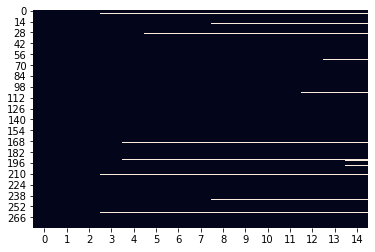

In [ ]:
sns.heatmap(X==0, vmin=0, vmax=1, cbar=False)
plt.show()

### Create the Matrix of Embedding

In [52]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  word_vect[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
#It can be navigated by word id, which can be obtained from the vocabulary.
word = "script"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 600 |idx
embeddings[idx]: (300,) |vector


### Deep Learning Model (Recurrent Neural Network)

In [127]:
from tensorflow.keras.constraints import max_norm
def fit_bert_classif(X_train, y_train, X_test, encode_y=False, dic_y_mapping=None, model=None, epochs=1, batch_size=16):
    ## encode y
    if encode_y is True:
        dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
        inverse_dic = {v:k for k,v in dic_y_mapping.items()}
        y_train = np.array( [inverse_dic[y] for y in y_train] )
    # print(dic_y_mapping)
    
    ## model
    if model is None:
        # input
        x_in = layers.Input(shape=(X_train.shape[1],))

        # embedding
        X = layers.Embedding(input_dim=embeddings.shape[0],  
                              output_dim=embeddings.shape[1], 
                              weights=[embeddings],
                              input_length=X_train.shape[1], trainable=True)(x_in)
        # 2 layers of bidirectional lstm
        X = layers.Bidirectional(layers.LSTM(90, dropout=0.3, return_sequences=True))(X)
        X = layers.Bidirectional(layers.LSTM(90))(X)

        # ## final dense 
        # X = layers.Dense(32, activation='tanh', kernel_constraint=max_norm(11))(X)
        # X = layers.Dense(32, activation='relu')(X)
        # X = layers.Dropout(0.1)(X)

        y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(X)
        ## compile
        model = Model(x_in, y_out)
        opt = Adam(learning_rate=0.1)
        model.compile(loss='sparse_categorical_crossentropy',
                    optimizer='adam', metrics=['accuracy'])
        # print(model.summary())
        
    ## train
    verbose = 1 if epochs > 1 else 2
    training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.2)
    if epochs > 1:
        utils_plot_keras_training(training)
    
    ## test
    predicted_prob = model.predict(X_test)
    predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob] if encode_y is True else [np.argmax(pred)]
    return training.model, predicted_prob, predicted

'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

### Define Target

In [54]:
y = df["Label"].values

### Train the Model

Epoch 1/10
21/21 [==============================] - 7s 113ms/step - loss: 1.8241 - accuracy: 0.3146 - val_loss: 1.3988 - val_accuracy: 0.5238
Epoch 2/10
21/21 [==============================] - 1s 57ms/step - loss: 0.9903 - accuracy: 0.7759 - val_loss: 0.9174 - val_accuracy: 0.7619
Epoch 3/10
21/21 [==============================] - 1s 56ms/step - loss: 0.3869 - accuracy: 0.9053 - val_loss: 0.7014 - val_accuracy: 0.8095
Epoch 4/10
21/21 [==============================] - 1s 55ms/step - loss: 0.1591 - accuracy: 0.9764 - val_loss: 0.5593 - val_accuracy: 0.8095
Epoch 5/10
21/21 [==============================] - 1s 55ms/step - loss: 0.0572 - accuracy: 0.9761 - val_loss: 0.9104 - val_accuracy: 0.7857
Epoch 6/10
21/21 [==============================] - 1s 56ms/step - loss: 0.0248 - accuracy: 0.9971 - val_loss: 0.9505 - val_accuracy: 0.8095
Epoch 7/10
21/21 [==============================] - 1s 56ms/step - loss: 0.0298 - accuracy: 0.9951 - val_loss: 0.8623 - val_accuracy: 0.8333
Epoch 8/10
2

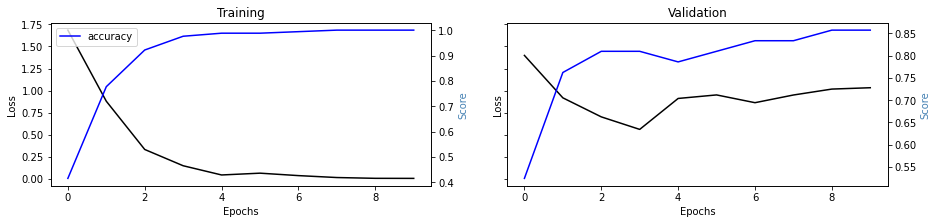

Iteração: 1 Fold: 1 Accuracy: 0.7307692307692307, Mean Accuracy: 0.7307692307692307
Epoch 1/10
21/21 [==============================] - 7s 110ms/step - loss: 1.9086 - accuracy: 0.2351 - val_loss: 1.2885 - val_accuracy: 0.7143
Epoch 2/10
21/21 [==============================] - 1s 53ms/step - loss: 1.0071 - accuracy: 0.8020 - val_loss: 0.6496 - val_accuracy: 0.8810
Epoch 3/10
21/21 [==============================] - 1s 54ms/step - loss: 0.4115 - accuracy: 0.9068 - val_loss: 0.5108 - val_accuracy: 0.8571
Epoch 4/10
21/21 [==============================] - 1s 55ms/step - loss: 0.1230 - accuracy: 0.9856 - val_loss: 0.6887 - val_accuracy: 0.7857
Epoch 5/10
21/21 [==============================] - 1s 57ms/step - loss: 0.0625 - accuracy: 0.9902 - val_loss: 0.4342 - val_accuracy: 0.9048
Epoch 6/10
21/21 [==============================] - 1s 55ms/step - loss: 0.0287 - accuracy: 0.9947 - val_loss: 0.4271 - val_accuracy: 0.9048
Epoch 7/10
21/21 [==============================] - 1s 57ms/step - lo

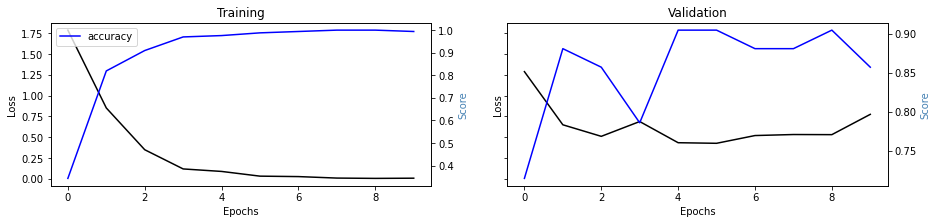

Iteração: 1 Fold: 2 Accuracy: 0.6730769230769231, Mean Accuracy: 0.7019230769230769
Epoch 1/10
21/21 [==============================] - 7s 115ms/step - loss: 1.8934 - accuracy: 0.2353 - val_loss: 1.5121 - val_accuracy: 0.5714
Epoch 2/10
21/21 [==============================] - 1s 59ms/step - loss: 1.0274 - accuracy: 0.7065 - val_loss: 1.0050 - val_accuracy: 0.5952
Epoch 3/10
21/21 [==============================] - 1s 56ms/step - loss: 0.5127 - accuracy: 0.8658 - val_loss: 0.9092 - val_accuracy: 0.7143
Epoch 4/10
21/21 [==============================] - 1s 56ms/step - loss: 0.1454 - accuracy: 0.9523 - val_loss: 1.0637 - val_accuracy: 0.6905
Epoch 5/10
21/21 [==============================] - 1s 54ms/step - loss: 0.1026 - accuracy: 0.9790 - val_loss: 0.8905 - val_accuracy: 0.8095
Epoch 6/10
21/21 [==============================] - 1s 56ms/step - loss: 0.0270 - accuracy: 0.9886 - val_loss: 0.8874 - val_accuracy: 0.8095
Epoch 7/10
21/21 [==============================] - 1s 55ms/step - lo

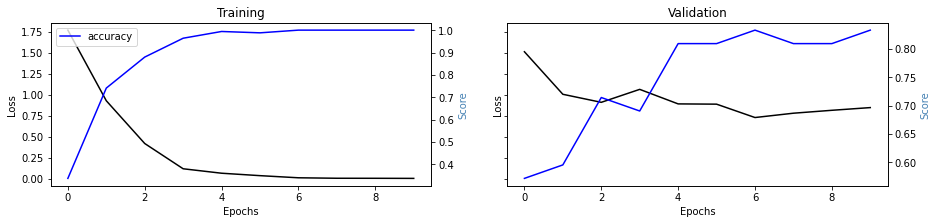

Iteração: 1 Fold: 3 Accuracy: 0.7692307692307693, Mean Accuracy: 0.7243589743589743
Epoch 1/10
21/21 [==============================] - 9s 116ms/step - loss: 1.8876 - accuracy: 0.2609 - val_loss: 1.4323 - val_accuracy: 0.4762
Epoch 2/10
21/21 [==============================] - 1s 58ms/step - loss: 1.1606 - accuracy: 0.6372 - val_loss: 0.8042 - val_accuracy: 0.7381
Epoch 3/10
21/21 [==============================] - 1s 57ms/step - loss: 0.4378 - accuracy: 0.9160 - val_loss: 1.2070 - val_accuracy: 0.6429
Epoch 4/10
21/21 [==============================] - 1s 57ms/step - loss: 0.1982 - accuracy: 0.9447 - val_loss: 1.2283 - val_accuracy: 0.6429
Epoch 5/10
21/21 [==============================] - 1s 59ms/step - loss: 0.0931 - accuracy: 0.9752 - val_loss: 0.9701 - val_accuracy: 0.7143
Epoch 6/10
21/21 [==============================] - 1s 58ms/step - loss: 0.0919 - accuracy: 0.9692 - val_loss: 1.0976 - val_accuracy: 0.6667
Epoch 7/10
21/21 [==============================] - 1s 58ms/step - lo

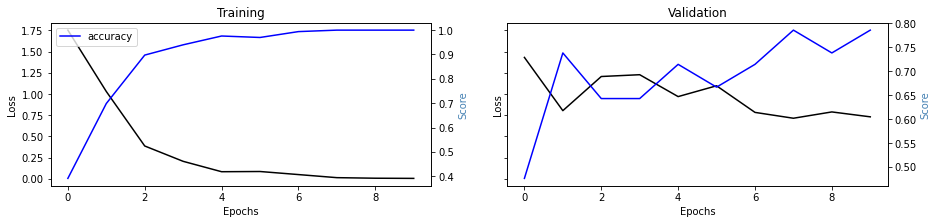

Iteração: 1 Fold: 4 Accuracy: 0.7884615384615384, Mean Accuracy: 0.7403846153846153
Epoch 1/10
21/21 [==============================] - 7s 116ms/step - loss: 1.8892 - accuracy: 0.2387 - val_loss: 1.5024 - val_accuracy: 0.4048
Epoch 2/10
21/21 [==============================] - 1s 58ms/step - loss: 1.0873 - accuracy: 0.7405 - val_loss: 0.8818 - val_accuracy: 0.7857
Epoch 3/10
21/21 [==============================] - 1s 59ms/step - loss: 0.4256 - accuracy: 0.9093 - val_loss: 0.7208 - val_accuracy: 0.8095
Epoch 4/10
21/21 [==============================] - 1s 56ms/step - loss: 0.1001 - accuracy: 0.9763 - val_loss: 0.9704 - val_accuracy: 0.7381
Epoch 5/10
21/21 [==============================] - 1s 58ms/step - loss: 0.0351 - accuracy: 0.9971 - val_loss: 0.9760 - val_accuracy: 0.7857
Epoch 6/10
21/21 [==============================] - 1s 57ms/step - loss: 0.0346 - accuracy: 0.9920 - val_loss: 0.9986 - val_accuracy: 0.7619
Epoch 7/10
21/21 [==============================] - 1s 57ms/step - lo

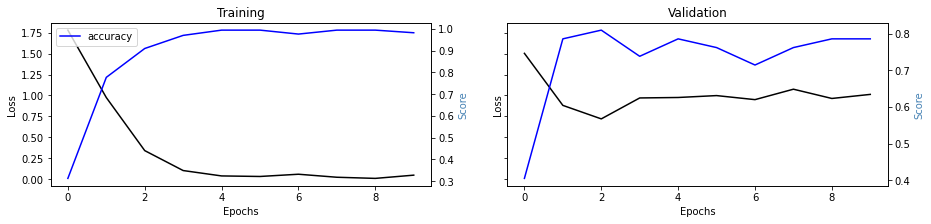

Iteração: 1 Fold: 5 Accuracy: 0.8653846153846154, Mean Accuracy: 0.7653846153846153
Epoch 1/10
21/21 [==============================] - 7s 116ms/step - loss: 1.8666 - accuracy: 0.2169 - val_loss: 1.2690 - val_accuracy: 0.8333
Epoch 2/10
21/21 [==============================] - 1s 57ms/step - loss: 1.0792 - accuracy: 0.7886 - val_loss: 0.7139 - val_accuracy: 0.8333
Epoch 3/10
21/21 [==============================] - 1s 59ms/step - loss: 0.4482 - accuracy: 0.9133 - val_loss: 0.7285 - val_accuracy: 0.8810
Epoch 4/10
21/21 [==============================] - 1s 58ms/step - loss: 0.2212 - accuracy: 0.9127 - val_loss: 0.4936 - val_accuracy: 0.8571
Epoch 5/10
21/21 [==============================] - 1s 58ms/step - loss: 0.0403 - accuracy: 0.9982 - val_loss: 0.4434 - val_accuracy: 0.9048
Epoch 6/10
21/21 [==============================] - 1s 59ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.4387 - val_accuracy: 0.9286
Epoch 7/10
21/21 [==============================] - 1s 58ms/step - lo

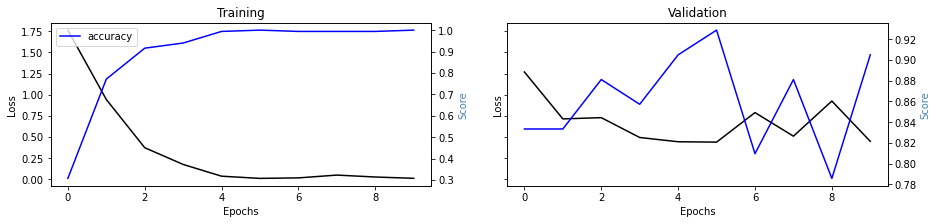

Iteração: 1 Fold: 6 Accuracy: 0.8461538461538461, Mean Accuracy: 0.7788461538461537
Epoch 1/10
21/21 [==============================] - 7s 115ms/step - loss: 1.8417 - accuracy: 0.2644 - val_loss: 1.3703 - val_accuracy: 0.4762
Epoch 2/10
21/21 [==============================] - 1s 59ms/step - loss: 0.9797 - accuracy: 0.7316 - val_loss: 0.9120 - val_accuracy: 0.6667
Epoch 3/10
21/21 [==============================] - 1s 58ms/step - loss: 0.3419 - accuracy: 0.8991 - val_loss: 0.9454 - val_accuracy: 0.7857
Epoch 4/10
21/21 [==============================] - 1s 58ms/step - loss: 0.1682 - accuracy: 0.9732 - val_loss: 1.0612 - val_accuracy: 0.6905
Epoch 5/10
21/21 [==============================] - 1s 59ms/step - loss: 0.0720 - accuracy: 0.9790 - val_loss: 0.8686 - val_accuracy: 0.7619
Epoch 6/10
21/21 [==============================] - 1s 60ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 1.0501 - val_accuracy: 0.7381
Epoch 7/10
21/21 [==============================] - 1s 58ms/step - lo

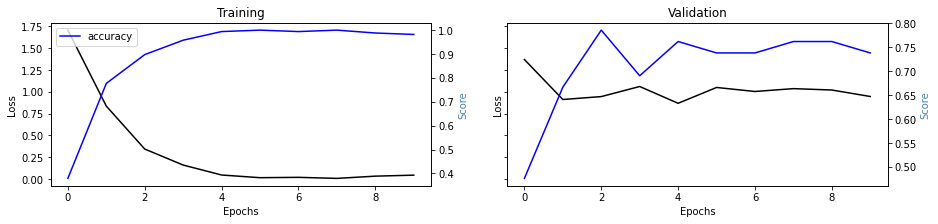

Iteração: 1 Fold: 7 Accuracy: 0.6730769230769231, Mean Accuracy: 0.7637362637362637
Epoch 1/10
21/21 [==============================] - 9s 117ms/step - loss: 1.8697 - accuracy: 0.2497 - val_loss: 1.5072 - val_accuracy: 0.4524
Epoch 2/10
21/21 [==============================] - 1s 58ms/step - loss: 1.0387 - accuracy: 0.8076 - val_loss: 1.3548 - val_accuracy: 0.5714
Epoch 3/10
21/21 [==============================] - 1s 59ms/step - loss: 0.4379 - accuracy: 0.8960 - val_loss: 1.3527 - val_accuracy: 0.5714
Epoch 4/10
21/21 [==============================] - 1s 59ms/step - loss: 0.1841 - accuracy: 0.9426 - val_loss: 1.1199 - val_accuracy: 0.7143
Epoch 5/10
21/21 [==============================] - 1s 57ms/step - loss: 0.0315 - accuracy: 1.0000 - val_loss: 1.2526 - val_accuracy: 0.7143
Epoch 6/10
21/21 [==============================] - 1s 57ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 1.1851 - val_accuracy: 0.7381
Epoch 7/10
21/21 [==============================] - 1s 56ms/step - lo

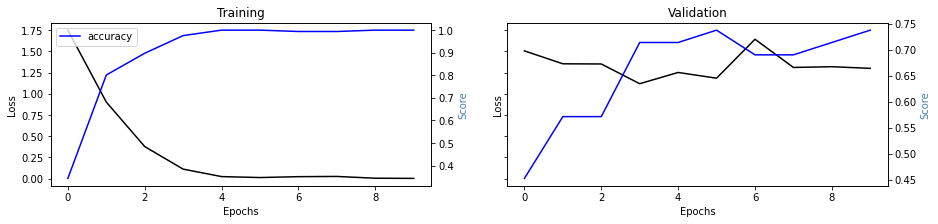

Iteração: 1 Fold: 8 Accuracy: 0.8076923076923077, Mean Accuracy: 0.7692307692307692
Epoch 1/10
21/21 [==============================] - 7s 115ms/step - loss: 1.7768 - accuracy: 0.2569 - val_loss: 1.3360 - val_accuracy: 0.5476
Epoch 2/10
21/21 [==============================] - 1s 57ms/step - loss: 0.9832 - accuracy: 0.7797 - val_loss: 0.7867 - val_accuracy: 0.7619
Epoch 3/10
21/21 [==============================] - 1s 59ms/step - loss: 0.4018 - accuracy: 0.8893 - val_loss: 0.7258 - val_accuracy: 0.7381
Epoch 4/10
21/21 [==============================] - 1s 58ms/step - loss: 0.1165 - accuracy: 0.9641 - val_loss: 0.6026 - val_accuracy: 0.8095
Epoch 5/10
21/21 [==============================] - 1s 55ms/step - loss: 0.0708 - accuracy: 0.9875 - val_loss: 0.8295 - val_accuracy: 0.7619
Epoch 6/10
21/21 [==============================] - 1s 58ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.5412 - val_accuracy: 0.8571
Epoch 7/10
21/21 [==============================] - 1s 57ms/step - lo

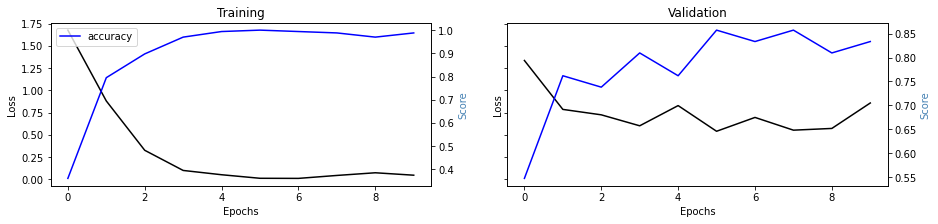

Iteração: 1 Fold: 9 Accuracy: 0.8846153846153846, Mean Accuracy: 0.782051282051282
Epoch 1/10
21/21 [==============================] - 7s 114ms/step - loss: 1.8820 - accuracy: 0.2349 - val_loss: 1.4115 - val_accuracy: 0.5476
Epoch 2/10
21/21 [==============================] - 1s 59ms/step - loss: 1.0924 - accuracy: 0.6680 - val_loss: 0.9872 - val_accuracy: 0.6905
Epoch 3/10
21/21 [==============================] - 1s 59ms/step - loss: 0.4527 - accuracy: 0.9043 - val_loss: 0.7342 - val_accuracy: 0.7619
Epoch 4/10
21/21 [==============================] - 1s 59ms/step - loss: 0.1142 - accuracy: 0.9962 - val_loss: 0.7077 - val_accuracy: 0.8333
Epoch 5/10
21/21 [==============================] - 1s 59ms/step - loss: 0.0376 - accuracy: 0.9929 - val_loss: 0.8780 - val_accuracy: 0.8333
Epoch 6/10
21/21 [==============================] - 1s 57ms/step - loss: 0.0275 - accuracy: 0.9920 - val_loss: 0.9054 - val_accuracy: 0.8095
Epoch 7/10
21/21 [==============================] - 1s 57ms/step - los

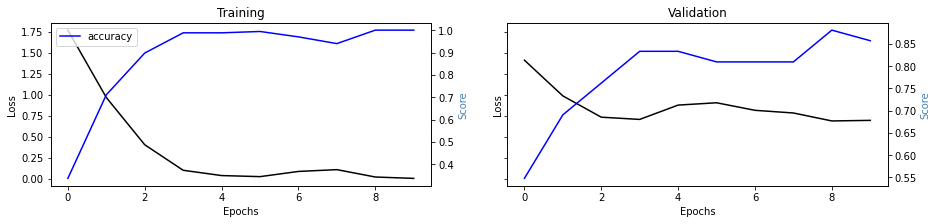

Iteração: 1 Fold: 10 Accuracy: 0.8461538461538461, Mean Accuracy: 0.7884615384615384
Epoch 1/10
21/21 [==============================] - 7s 114ms/step - loss: 1.8865 - accuracy: 0.2386 - val_loss: 1.4449 - val_accuracy: 0.6429
Epoch 2/10
21/21 [==============================] - 1s 59ms/step - loss: 1.0985 - accuracy: 0.6928 - val_loss: 0.8391 - val_accuracy: 0.7143
Epoch 3/10
21/21 [==============================] - 1s 61ms/step - loss: 0.3816 - accuracy: 0.8812 - val_loss: 0.6956 - val_accuracy: 0.7857
Epoch 4/10
21/21 [==============================] - 1s 59ms/step - loss: 0.1387 - accuracy: 0.9622 - val_loss: 0.8086 - val_accuracy: 0.7857
Epoch 5/10
21/21 [==============================] - 1s 59ms/step - loss: 0.0325 - accuracy: 0.9975 - val_loss: 0.8147 - val_accuracy: 0.8571
Epoch 6/10
21/21 [==============================] - 1s 58ms/step - loss: 0.0177 - accuracy: 0.9995 - val_loss: 0.9815 - val_accuracy: 0.8095
Epoch 7/10
21/21 [==============================] - 1s 58ms/step - l

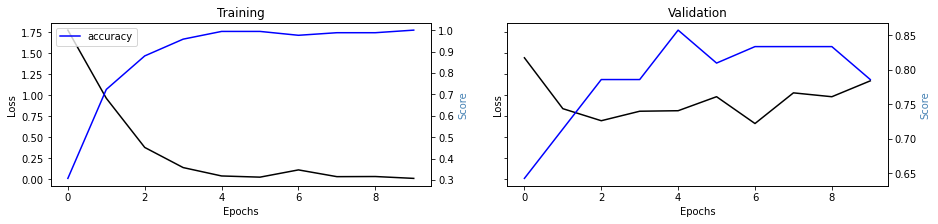

Iteração: 2 Fold: 1 Accuracy: 0.7884615384615384, Mean Accuracy: 0.7884615384615384
Epoch 1/10
21/21 [==============================] - 9s 119ms/step - loss: 1.8427 - accuracy: 0.2382 - val_loss: 1.2110 - val_accuracy: 0.6429
Epoch 2/10
21/21 [==============================] - 1s 58ms/step - loss: 1.0359 - accuracy: 0.7644 - val_loss: 0.5050 - val_accuracy: 0.8333
Epoch 3/10
21/21 [==============================] - 1s 59ms/step - loss: 0.3771 - accuracy: 0.9398 - val_loss: 0.2511 - val_accuracy: 0.9286
Epoch 4/10
21/21 [==============================] - 1s 58ms/step - loss: 0.2076 - accuracy: 0.9381 - val_loss: 0.3525 - val_accuracy: 0.9286
Epoch 5/10
21/21 [==============================] - 1s 58ms/step - loss: 0.1110 - accuracy: 0.9858 - val_loss: 0.2785 - val_accuracy: 0.9048
Epoch 6/10
21/21 [==============================] - 1s 59ms/step - loss: 0.0344 - accuracy: 0.9897 - val_loss: 0.2763 - val_accuracy: 0.9048
Epoch 7/10
21/21 [==============================] - 1s 56ms/step - lo

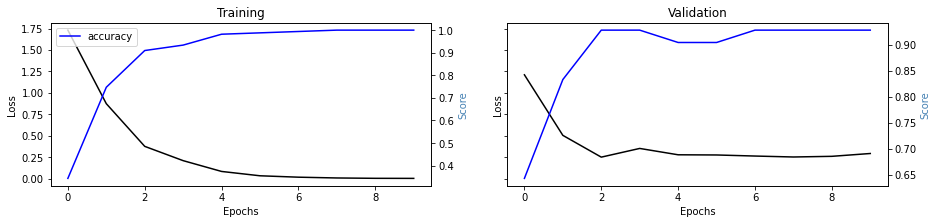

Iteração: 2 Fold: 2 Accuracy: 0.7115384615384616, Mean Accuracy: 0.75
Epoch 1/10
21/21 [==============================] - 7s 116ms/step - loss: 1.8392 - accuracy: 0.3052 - val_loss: 1.3201 - val_accuracy: 0.7381
Epoch 2/10
21/21 [==============================] - 1s 58ms/step - loss: 0.9885 - accuracy: 0.7443 - val_loss: 0.9466 - val_accuracy: 0.6190
Epoch 3/10
21/21 [==============================] - 1s 59ms/step - loss: 0.4000 - accuracy: 0.8603 - val_loss: 0.7425 - val_accuracy: 0.6429
Epoch 4/10
21/21 [==============================] - 1s 58ms/step - loss: 0.1728 - accuracy: 0.9474 - val_loss: 0.6258 - val_accuracy: 0.8333
Epoch 5/10
21/21 [==============================] - 1s 58ms/step - loss: 0.0458 - accuracy: 0.9937 - val_loss: 0.6077 - val_accuracy: 0.8333
Epoch 6/10
21/21 [==============================] - 1s 57ms/step - loss: 0.0252 - accuracy: 0.9945 - val_loss: 0.7239 - val_accuracy: 0.8333
Epoch 7/10
21/21 [==============================] - 1s 58ms/step - loss: 0.0092 - a

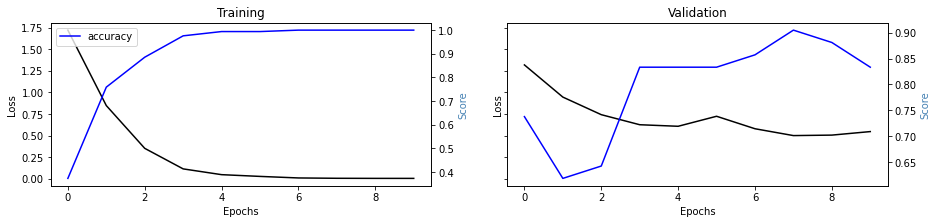

Iteração: 2 Fold: 3 Accuracy: 0.75, Mean Accuracy: 0.75
Epoch 1/10
21/21 [==============================] - 7s 117ms/step - loss: 1.8431 - accuracy: 0.3248 - val_loss: 1.4170 - val_accuracy: 0.4762
Epoch 2/10
21/21 [==============================] - 1s 59ms/step - loss: 1.1193 - accuracy: 0.7547 - val_loss: 0.9080 - val_accuracy: 0.6190
Epoch 3/10
21/21 [==============================] - 1s 59ms/step - loss: 0.4715 - accuracy: 0.8232 - val_loss: 0.6539 - val_accuracy: 0.7381
Epoch 4/10
21/21 [==============================] - 1s 58ms/step - loss: 0.3134 - accuracy: 0.9080 - val_loss: 1.1614 - val_accuracy: 0.6429
Epoch 5/10
21/21 [==============================] - 1s 57ms/step - loss: 0.0998 - accuracy: 0.9740 - val_loss: 0.8571 - val_accuracy: 0.7381
Epoch 6/10
21/21 [==============================] - 1s 59ms/step - loss: 0.0260 - accuracy: 0.9964 - val_loss: 0.9741 - val_accuracy: 0.7381
Epoch 7/10
21/21 [==============================] - 1s 57ms/step - loss: 0.0421 - accuracy: 0.990

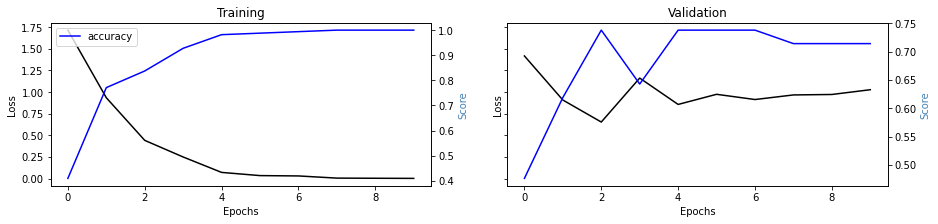

Iteração: 2 Fold: 4 Accuracy: 0.7115384615384616, Mean Accuracy: 0.7403846153846154
Epoch 1/10
21/21 [==============================] - 7s 115ms/step - loss: 1.8786 - accuracy: 0.2488 - val_loss: 1.3121 - val_accuracy: 0.5952
Epoch 2/10
21/21 [==============================] - 1s 60ms/step - loss: 1.0603 - accuracy: 0.7248 - val_loss: 1.0474 - val_accuracy: 0.6667
Epoch 3/10
21/21 [==============================] - 1s 60ms/step - loss: 0.4905 - accuracy: 0.8524 - val_loss: 0.8402 - val_accuracy: 0.7381
Epoch 4/10
21/21 [==============================] - 1s 59ms/step - loss: 0.1899 - accuracy: 0.9588 - val_loss: 0.5447 - val_accuracy: 0.9048
Epoch 5/10
21/21 [==============================] - 1s 59ms/step - loss: 0.0678 - accuracy: 0.9828 - val_loss: 1.0269 - val_accuracy: 0.6905
Epoch 6/10
21/21 [==============================] - 1s 60ms/step - loss: 0.1415 - accuracy: 0.9741 - val_loss: 0.8030 - val_accuracy: 0.7857
Epoch 7/10
21/21 [==============================] - 1s 59ms/step - lo

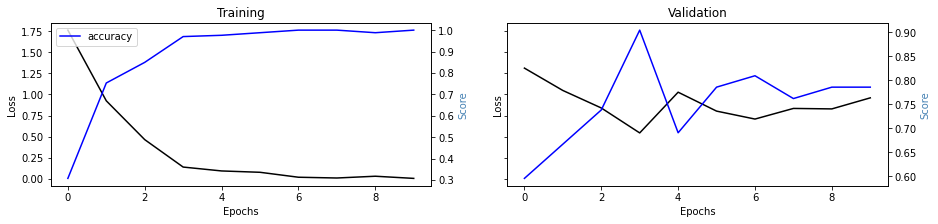

Iteração: 2 Fold: 5 Accuracy: 0.9615384615384616, Mean Accuracy: 0.7846153846153847
Epoch 1/10
21/21 [==============================] - 9s 116ms/step - loss: 1.8504 - accuracy: 0.2908 - val_loss: 1.2952 - val_accuracy: 0.6190
Epoch 2/10
21/21 [==============================] - 1s 59ms/step - loss: 1.0933 - accuracy: 0.7911 - val_loss: 0.8894 - val_accuracy: 0.7381
Epoch 3/10
21/21 [==============================] - 1s 60ms/step - loss: 0.4114 - accuracy: 0.9395 - val_loss: 0.5750 - val_accuracy: 0.8333
Epoch 4/10
21/21 [==============================] - 1s 58ms/step - loss: 0.0811 - accuracy: 0.9873 - val_loss: 0.6918 - val_accuracy: 0.8095
Epoch 5/10
21/21 [==============================] - 1s 58ms/step - loss: 0.1245 - accuracy: 0.9574 - val_loss: 0.7106 - val_accuracy: 0.8333
Epoch 6/10
21/21 [==============================] - 1s 59ms/step - loss: 0.0992 - accuracy: 0.9724 - val_loss: 0.7360 - val_accuracy: 0.8095
Epoch 7/10
21/21 [==============================] - 1s 60ms/step - lo

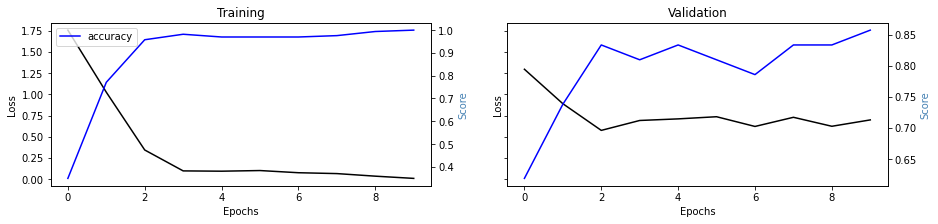

Iteração: 2 Fold: 6 Accuracy: 0.7692307692307693, Mean Accuracy: 0.782051282051282
Epoch 1/10
21/21 [==============================] - 7s 117ms/step - loss: 1.8658 - accuracy: 0.2449 - val_loss: 1.4832 - val_accuracy: 0.3810
Epoch 2/10
21/21 [==============================] - 1s 58ms/step - loss: 0.9748 - accuracy: 0.6981 - val_loss: 1.1317 - val_accuracy: 0.6190
Epoch 3/10
21/21 [==============================] - 1s 60ms/step - loss: 0.5137 - accuracy: 0.8556 - val_loss: 0.8808 - val_accuracy: 0.7381
Epoch 4/10
21/21 [==============================] - 1s 59ms/step - loss: 0.1598 - accuracy: 0.9700 - val_loss: 1.1153 - val_accuracy: 0.7143
Epoch 5/10
21/21 [==============================] - 1s 59ms/step - loss: 0.0759 - accuracy: 0.9872 - val_loss: 0.6201 - val_accuracy: 0.7857
Epoch 6/10
21/21 [==============================] - 1s 59ms/step - loss: 0.0196 - accuracy: 0.9945 - val_loss: 0.4855 - val_accuracy: 0.9048
Epoch 7/10
21/21 [==============================] - 1s 59ms/step - los

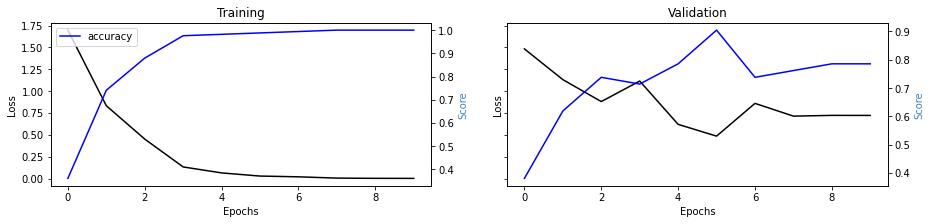

Iteração: 2 Fold: 7 Accuracy: 0.7115384615384616, Mean Accuracy: 0.771978021978022
Epoch 1/10
21/21 [==============================] - 7s 116ms/step - loss: 1.8579 - accuracy: 0.2628 - val_loss: 1.5410 - val_accuracy: 0.4286
Epoch 2/10
21/21 [==============================] - 1s 60ms/step - loss: 1.0132 - accuracy: 0.7645 - val_loss: 1.3086 - val_accuracy: 0.5952
Epoch 3/10
21/21 [==============================] - 1s 59ms/step - loss: 0.4095 - accuracy: 0.8562 - val_loss: 1.6278 - val_accuracy: 0.5952
Epoch 4/10
21/21 [==============================] - 1s 58ms/step - loss: 0.1833 - accuracy: 0.9577 - val_loss: 1.4180 - val_accuracy: 0.6429
Epoch 5/10
21/21 [==============================] - 1s 58ms/step - loss: 0.0426 - accuracy: 0.9925 - val_loss: 1.2716 - val_accuracy: 0.7619
Epoch 6/10
21/21 [==============================] - 1s 58ms/step - loss: 0.0636 - accuracy: 0.9832 - val_loss: 1.3971 - val_accuracy: 0.6905
Epoch 7/10
21/21 [==============================] - 1s 59ms/step - los

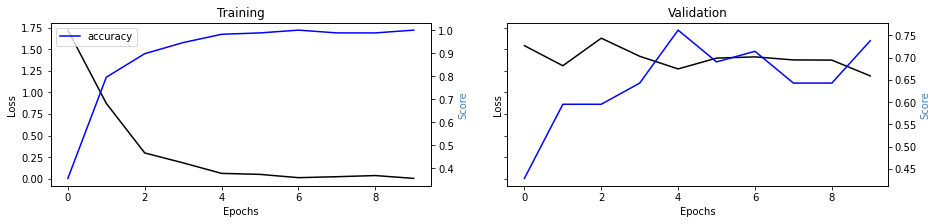

Iteração: 2 Fold: 8 Accuracy: 0.7692307692307693, Mean Accuracy: 0.7716346153846154
Epoch 1/10
21/21 [==============================] - 7s 117ms/step - loss: 1.8594 - accuracy: 0.2607 - val_loss: 1.3251 - val_accuracy: 0.7143
Epoch 2/10
21/21 [==============================] - 1s 61ms/step - loss: 0.9127 - accuracy: 0.7924 - val_loss: 0.7411 - val_accuracy: 0.8095
Epoch 3/10
21/21 [==============================] - 1s 61ms/step - loss: 0.4200 - accuracy: 0.9149 - val_loss: 1.1091 - val_accuracy: 0.6190
Epoch 4/10
21/21 [==============================] - 1s 60ms/step - loss: 0.3576 - accuracy: 0.8891 - val_loss: 0.6761 - val_accuracy: 0.8333
Epoch 5/10
21/21 [==============================] - 1s 59ms/step - loss: 0.1061 - accuracy: 0.9874 - val_loss: 0.6080 - val_accuracy: 0.8333
Epoch 6/10
21/21 [==============================] - 1s 60ms/step - loss: 0.0358 - accuracy: 0.9937 - val_loss: 0.6568 - val_accuracy: 0.8571
Epoch 7/10
21/21 [==============================] - 1s 60ms/step - lo

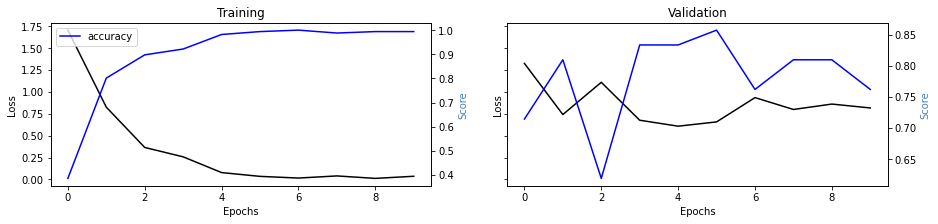

Iteração: 2 Fold: 9 Accuracy: 0.9038461538461539, Mean Accuracy: 0.7863247863247864
Epoch 1/10
21/21 [==============================] - 9s 119ms/step - loss: 1.9103 - accuracy: 0.2548 - val_loss: 1.3385 - val_accuracy: 0.4762
Epoch 2/10
21/21 [==============================] - 1s 61ms/step - loss: 1.1039 - accuracy: 0.6275 - val_loss: 0.9443 - val_accuracy: 0.6667
Epoch 3/10
21/21 [==============================] - 1s 61ms/step - loss: 0.5003 - accuracy: 0.8629 - val_loss: 0.7190 - val_accuracy: 0.7381
Epoch 4/10
21/21 [==============================] - 1s 61ms/step - loss: 0.2026 - accuracy: 0.9613 - val_loss: 0.9374 - val_accuracy: 0.7381
Epoch 5/10
21/21 [==============================] - 1s 61ms/step - loss: 0.1432 - accuracy: 0.9495 - val_loss: 0.8353 - val_accuracy: 0.8095
Epoch 6/10
21/21 [==============================] - 1s 62ms/step - loss: 0.0385 - accuracy: 0.9945 - val_loss: 0.8662 - val_accuracy: 0.8095
Epoch 7/10
21/21 [==============================] - 1s 61ms/step - lo

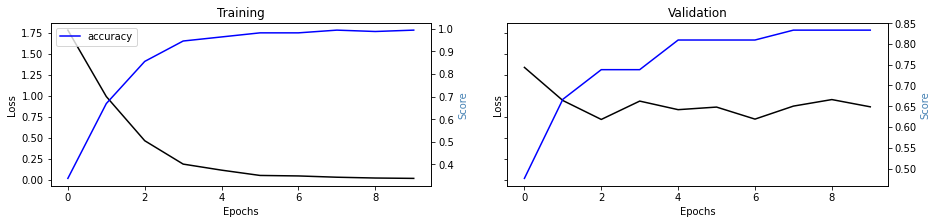

Iteração: 2 Fold: 10 Accuracy: 0.8269230769230769, Mean Accuracy: 0.7903846153846155
Epoch 1/10
21/21 [==============================] - 7s 116ms/step - loss: 1.8713 - accuracy: 0.2707 - val_loss: 1.4848 - val_accuracy: 0.4524
Epoch 2/10
21/21 [==============================] - 1s 60ms/step - loss: 0.9718 - accuracy: 0.7598 - val_loss: 0.8854 - val_accuracy: 0.8095
Epoch 3/10
21/21 [==============================] - 1s 61ms/step - loss: 0.4913 - accuracy: 0.8896 - val_loss: 0.7373 - val_accuracy: 0.7619
Epoch 4/10
21/21 [==============================] - 1s 59ms/step - loss: 0.1583 - accuracy: 0.9596 - val_loss: 0.7804 - val_accuracy: 0.7619
Epoch 5/10
21/21 [==============================] - 1s 62ms/step - loss: 0.0666 - accuracy: 0.9908 - val_loss: 0.6223 - val_accuracy: 0.8571
Epoch 6/10
21/21 [==============================] - 1s 60ms/step - loss: 0.0236 - accuracy: 0.9986 - val_loss: 0.7527 - val_accuracy: 0.8571
Epoch 7/10
21/21 [==============================] - 1s 61ms/step - l

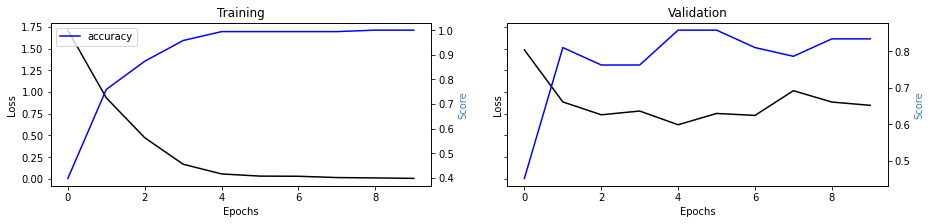

Iteração: 3 Fold: 1 Accuracy: 0.7884615384615384, Mean Accuracy: 0.7884615384615384
Epoch 1/10
21/21 [==============================] - 7s 118ms/step - loss: 1.9129 - accuracy: 0.2400 - val_loss: 1.4123 - val_accuracy: 0.5238
Epoch 2/10
21/21 [==============================] - 1s 61ms/step - loss: 1.1962 - accuracy: 0.6942 - val_loss: 0.6993 - val_accuracy: 0.8333
Epoch 3/10
21/21 [==============================] - 1s 61ms/step - loss: 0.5716 - accuracy: 0.8429 - val_loss: 0.7315 - val_accuracy: 0.7857
Epoch 4/10
21/21 [==============================] - 1s 61ms/step - loss: 0.2289 - accuracy: 0.9337 - val_loss: 0.3221 - val_accuracy: 0.9286
Epoch 5/10
21/21 [==============================] - 1s 60ms/step - loss: 0.0457 - accuracy: 0.9992 - val_loss: 0.2947 - val_accuracy: 0.8810
Epoch 6/10
21/21 [==============================] - 1s 61ms/step - loss: 0.0399 - accuracy: 0.9962 - val_loss: 0.4608 - val_accuracy: 0.8571
Epoch 7/10
21/21 [==============================] - 1s 62ms/step - lo

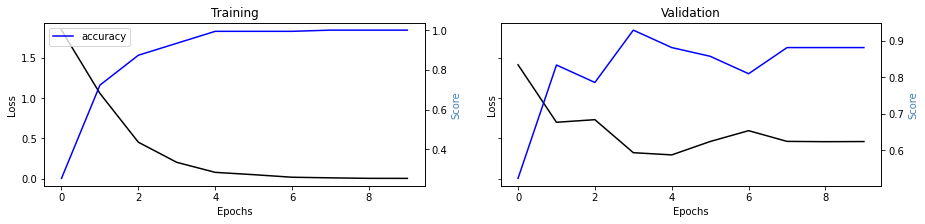

Iteração: 3 Fold: 2 Accuracy: 0.7692307692307693, Mean Accuracy: 0.7788461538461539
Epoch 1/10
21/21 [==============================] - 7s 115ms/step - loss: 1.8664 - accuracy: 0.2740 - val_loss: 1.4138 - val_accuracy: 0.5238
Epoch 2/10
21/21 [==============================] - 1s 60ms/step - loss: 1.0764 - accuracy: 0.6781 - val_loss: 0.8772 - val_accuracy: 0.7381
Epoch 3/10
21/21 [==============================] - 1s 61ms/step - loss: 0.4387 - accuracy: 0.8895 - val_loss: 0.6852 - val_accuracy: 0.7143
Epoch 4/10
21/21 [==============================] - 1s 60ms/step - loss: 0.2059 - accuracy: 0.9658 - val_loss: 0.8124 - val_accuracy: 0.7857
Epoch 5/10
21/21 [==============================] - 1s 60ms/step - loss: 0.1199 - accuracy: 0.9508 - val_loss: 0.6069 - val_accuracy: 0.7619
Epoch 6/10
21/21 [==============================] - 1s 60ms/step - loss: 0.0304 - accuracy: 0.9929 - val_loss: 0.6840 - val_accuracy: 0.8333
Epoch 7/10
21/21 [==============================] - 1s 60ms/step - lo

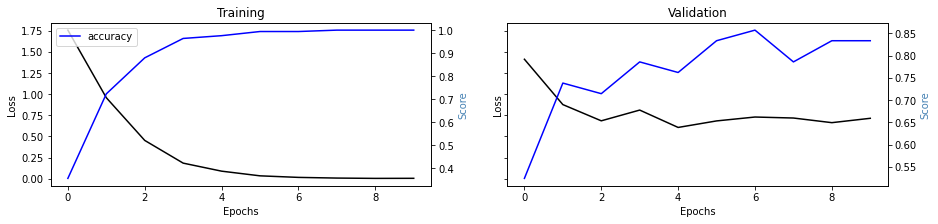

Iteração: 3 Fold: 3 Accuracy: 0.7884615384615384, Mean Accuracy: 0.782051282051282
Epoch 1/10
21/21 [==============================] - 9s 118ms/step - loss: 1.8534 - accuracy: 0.2288 - val_loss: 1.3223 - val_accuracy: 0.5000
Epoch 2/10
21/21 [==============================] - 1s 60ms/step - loss: 1.0301 - accuracy: 0.7611 - val_loss: 1.0215 - val_accuracy: 0.6429
Epoch 3/10
21/21 [==============================] - 1s 61ms/step - loss: 0.3881 - accuracy: 0.8814 - val_loss: 0.6632 - val_accuracy: 0.8095
Epoch 4/10
21/21 [==============================] - 1s 61ms/step - loss: 0.2154 - accuracy: 0.9383 - val_loss: 0.7637 - val_accuracy: 0.7857
Epoch 5/10
21/21 [==============================] - 1s 61ms/step - loss: 0.0872 - accuracy: 0.9894 - val_loss: 0.9936 - val_accuracy: 0.7381
Epoch 6/10
21/21 [==============================] - 1s 61ms/step - loss: 0.0180 - accuracy: 0.9989 - val_loss: 0.7466 - val_accuracy: 0.8095
Epoch 7/10
21/21 [==============================] - 1s 61ms/step - los

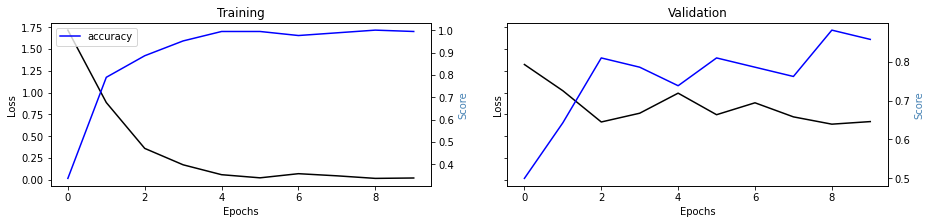

Iteração: 3 Fold: 4 Accuracy: 0.7884615384615384, Mean Accuracy: 0.7836538461538461
Epoch 1/10
21/21 [==============================] - 7s 119ms/step - loss: 1.8345 - accuracy: 0.2433 - val_loss: 1.3204 - val_accuracy: 0.6667
Epoch 2/10
21/21 [==============================] - 1s 60ms/step - loss: 0.9975 - accuracy: 0.8268 - val_loss: 0.9245 - val_accuracy: 0.6905
Epoch 3/10
21/21 [==============================] - 1s 59ms/step - loss: 0.3408 - accuracy: 0.9330 - val_loss: 1.0284 - val_accuracy: 0.6429
Epoch 4/10
21/21 [==============================] - 1s 61ms/step - loss: 0.2404 - accuracy: 0.9101 - val_loss: 0.8933 - val_accuracy: 0.7857
Epoch 5/10
21/21 [==============================] - 1s 61ms/step - loss: 0.0552 - accuracy: 0.9986 - val_loss: 0.9696 - val_accuracy: 0.7619
Epoch 6/10
21/21 [==============================] - 1s 61ms/step - loss: 0.0646 - accuracy: 0.9718 - val_loss: 0.9616 - val_accuracy: 0.7619
Epoch 7/10
21/21 [==============================] - 1s 60ms/step - lo

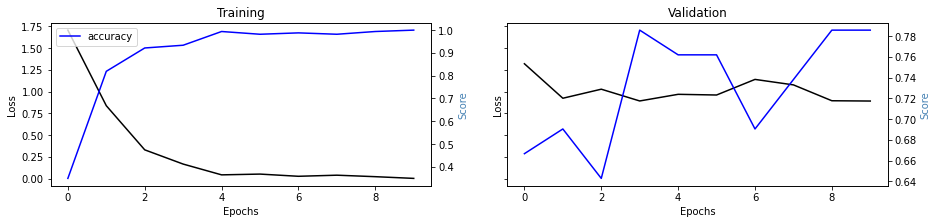

Iteração: 3 Fold: 5 Accuracy: 0.9038461538461539, Mean Accuracy: 0.8076923076923077
Epoch 1/10
21/21 [==============================] - 7s 116ms/step - loss: 1.8345 - accuracy: 0.2251 - val_loss: 1.1007 - val_accuracy: 0.6905
Epoch 2/10
21/21 [==============================] - 1s 61ms/step - loss: 0.9551 - accuracy: 0.7056 - val_loss: 0.6821 - val_accuracy: 0.9286
Epoch 3/10
21/21 [==============================] - 1s 62ms/step - loss: 0.5789 - accuracy: 0.7623 - val_loss: 0.5538 - val_accuracy: 0.8095
Epoch 4/10
21/21 [==============================] - 1s 62ms/step - loss: 0.1365 - accuracy: 0.9871 - val_loss: 0.5320 - val_accuracy: 0.9286
Epoch 5/10
21/21 [==============================] - 1s 62ms/step - loss: 0.0569 - accuracy: 0.9826 - val_loss: 0.5234 - val_accuracy: 0.9048
Epoch 6/10
21/21 [==============================] - 1s 61ms/step - loss: 0.0222 - accuracy: 0.9982 - val_loss: 0.5440 - val_accuracy: 0.8810
Epoch 7/10
21/21 [==============================] - 1s 64ms/step - lo

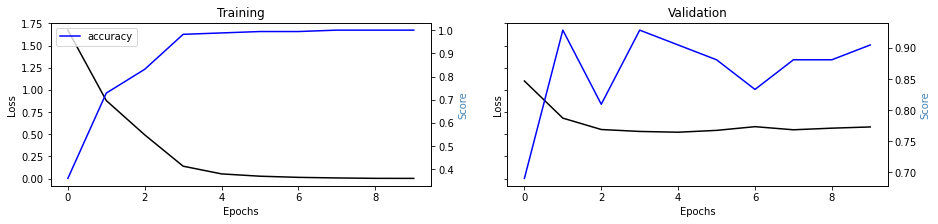

Iteração: 3 Fold: 6 Accuracy: 0.8269230769230769, Mean Accuracy: 0.8108974358974358
Epoch 1/10
21/21 [==============================] - 7s 116ms/step - loss: 1.8600 - accuracy: 0.2387 - val_loss: 1.4198 - val_accuracy: 0.4762
Epoch 2/10
21/21 [==============================] - 1s 62ms/step - loss: 0.9312 - accuracy: 0.7782 - val_loss: 1.0480 - val_accuracy: 0.6190
Epoch 3/10
21/21 [==============================] - 1s 61ms/step - loss: 0.4201 - accuracy: 0.8682 - val_loss: 0.8652 - val_accuracy: 0.6905
Epoch 4/10
21/21 [==============================] - 1s 61ms/step - loss: 0.1449 - accuracy: 0.9644 - val_loss: 0.5355 - val_accuracy: 0.8333
Epoch 5/10
21/21 [==============================] - 1s 62ms/step - loss: 0.0469 - accuracy: 0.9910 - val_loss: 1.0773 - val_accuracy: 0.6667
Epoch 6/10
21/21 [==============================] - 1s 62ms/step - loss: 0.1064 - accuracy: 0.9511 - val_loss: 0.9133 - val_accuracy: 0.7381
Epoch 7/10
21/21 [==============================] - 1s 61ms/step - lo

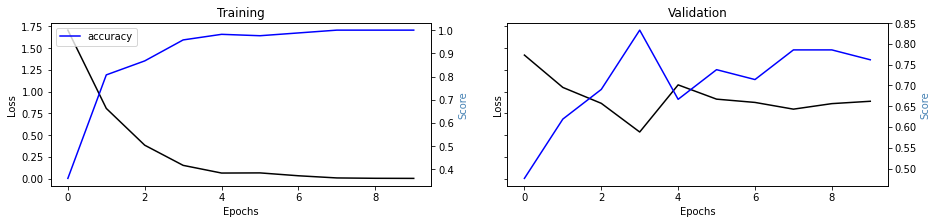

Iteração: 3 Fold: 7 Accuracy: 0.6923076923076923, Mean Accuracy: 0.7939560439560439
Epoch 1/10
21/21 [==============================] - 9s 215ms/step - loss: 1.8759 - accuracy: 0.2779 - val_loss: 1.4939 - val_accuracy: 0.5476
Epoch 2/10
21/21 [==============================] - 1s 60ms/step - loss: 0.9718 - accuracy: 0.7923 - val_loss: 1.4977 - val_accuracy: 0.4762
Epoch 3/10
21/21 [==============================] - 1s 62ms/step - loss: 0.4779 - accuracy: 0.8695 - val_loss: 1.2299 - val_accuracy: 0.6667
Epoch 4/10
21/21 [==============================] - 1s 62ms/step - loss: 0.1433 - accuracy: 0.9788 - val_loss: 1.2184 - val_accuracy: 0.7143
Epoch 5/10
21/21 [==============================] - 1s 61ms/step - loss: 0.0477 - accuracy: 1.0000 - val_loss: 1.1560 - val_accuracy: 0.7381
Epoch 6/10
21/21 [==============================] - 1s 61ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 1.2558 - val_accuracy: 0.7381
Epoch 7/10
21/21 [==============================] - 1s 62ms/step - lo

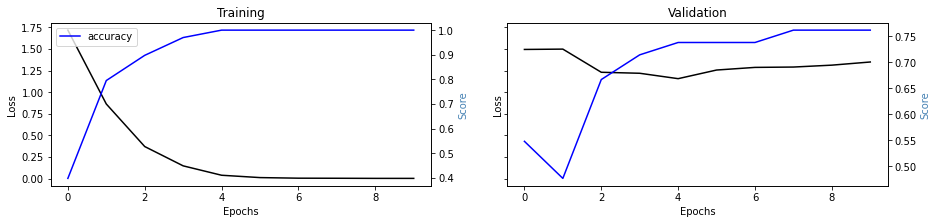

Iteração: 3 Fold: 8 Accuracy: 0.7692307692307693, Mean Accuracy: 0.7908653846153846
Epoch 1/10
21/21 [==============================] - 7s 121ms/step - loss: 1.8893 - accuracy: 0.2685 - val_loss: 1.4958 - val_accuracy: 0.5952
Epoch 2/10
21/21 [==============================] - 1s 63ms/step - loss: 1.1206 - accuracy: 0.7657 - val_loss: 0.8396 - val_accuracy: 0.8095
Epoch 3/10
21/21 [==============================] - 1s 61ms/step - loss: 0.4810 - accuracy: 0.8628 - val_loss: 0.6652 - val_accuracy: 0.8333
Epoch 4/10
21/21 [==============================] - 1s 61ms/step - loss: 0.2360 - accuracy: 0.9149 - val_loss: 0.5937 - val_accuracy: 0.8333
Epoch 5/10
21/21 [==============================] - 1s 62ms/step - loss: 0.1245 - accuracy: 0.9592 - val_loss: 0.7360 - val_accuracy: 0.8095
Epoch 6/10
21/21 [==============================] - 1s 63ms/step - loss: 0.0864 - accuracy: 0.9713 - val_loss: 0.6721 - val_accuracy: 0.8095
Epoch 7/10
21/21 [==============================] - 1s 62ms/step - lo

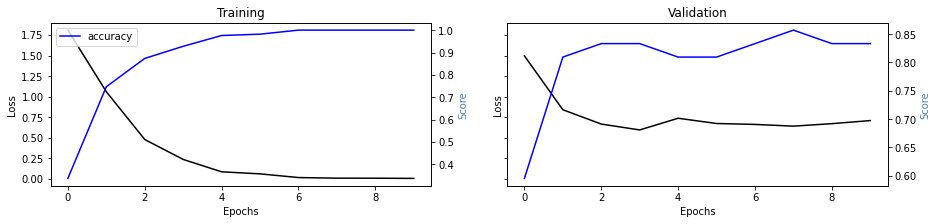

Iteração: 3 Fold: 9 Accuracy: 0.8846153846153846, Mean Accuracy: 0.8012820512820513
Epoch 1/10
21/21 [==============================] - 7s 120ms/step - loss: 1.8839 - accuracy: 0.2313 - val_loss: 1.3177 - val_accuracy: 0.6429
Epoch 2/10
21/21 [==============================] - 1s 63ms/step - loss: 1.1439 - accuracy: 0.6556 - val_loss: 0.9403 - val_accuracy: 0.6667
Epoch 3/10
21/21 [==============================] - 1s 63ms/step - loss: 0.4647 - accuracy: 0.8890 - val_loss: 0.7819 - val_accuracy: 0.7619
Epoch 4/10
21/21 [==============================] - 1s 62ms/step - loss: 0.2412 - accuracy: 0.9443 - val_loss: 0.7218 - val_accuracy: 0.8333
Epoch 5/10
21/21 [==============================] - 1s 62ms/step - loss: 0.0984 - accuracy: 0.9945 - val_loss: 0.6690 - val_accuracy: 0.8095
Epoch 6/10
21/21 [==============================] - 1s 63ms/step - loss: 0.0294 - accuracy: 0.9992 - val_loss: 0.6427 - val_accuracy: 0.8571
Epoch 7/10
21/21 [==============================] - 1s 62ms/step - lo

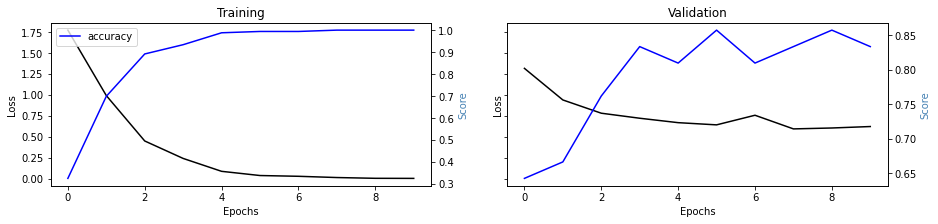

Iteração: 3 Fold: 10 Accuracy: 0.7884615384615384, Mean Accuracy: 0.8
Epoch 1/10
21/21 [==============================] - 7s 118ms/step - loss: 1.8930 - accuracy: 0.1944 - val_loss: 1.5355 - val_accuracy: 0.4524
Epoch 2/10
21/21 [==============================] - 1s 65ms/step - loss: 1.1140 - accuracy: 0.7149 - val_loss: 0.9635 - val_accuracy: 0.7143
Epoch 3/10
21/21 [==============================] - 1s 62ms/step - loss: 0.4327 - accuracy: 0.8864 - val_loss: 0.6095 - val_accuracy: 0.7857
Epoch 4/10
21/21 [==============================] - 1s 64ms/step - loss: 0.0758 - accuracy: 0.9930 - val_loss: 0.6613 - val_accuracy: 0.8333
Epoch 5/10
21/21 [==============================] - 1s 63ms/step - loss: 0.0933 - accuracy: 0.9666 - val_loss: 0.7402 - val_accuracy: 0.8095
Epoch 6/10
21/21 [==============================] - 1s 63ms/step - loss: 0.0436 - accuracy: 1.0000 - val_loss: 0.8882 - val_accuracy: 0.8095
Epoch 7/10
21/21 [==============================] - 1s 64ms/step - loss: 0.0087 - a

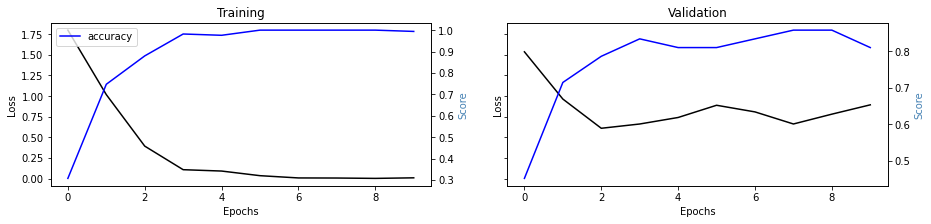

Iteração: 4 Fold: 1 Accuracy: 0.75, Mean Accuracy: 0.75
Epoch 1/10
21/21 [==============================] - 7s 118ms/step - loss: 1.8659 - accuracy: 0.2919 - val_loss: 1.2429 - val_accuracy: 0.5714
Epoch 2/10
21/21 [==============================] - 1s 62ms/step - loss: 0.9421 - accuracy: 0.7537 - val_loss: 0.6770 - val_accuracy: 0.8333
Epoch 3/10
21/21 [==============================] - 1s 62ms/step - loss: 0.4195 - accuracy: 0.8668 - val_loss: 0.6147 - val_accuracy: 0.8333
Epoch 4/10
21/21 [==============================] - 1s 63ms/step - loss: 0.1441 - accuracy: 0.9633 - val_loss: 0.4687 - val_accuracy: 0.8810
Epoch 5/10
21/21 [==============================] - 1s 63ms/step - loss: 0.0656 - accuracy: 0.9788 - val_loss: 0.8367 - val_accuracy: 0.8095
Epoch 6/10
21/21 [==============================] - 1s 62ms/step - loss: 0.0435 - accuracy: 0.9847 - val_loss: 0.5080 - val_accuracy: 0.8810
Epoch 7/10
21/21 [==============================] - 1s 63ms/step - loss: 0.0110 - accuracy: 1.000

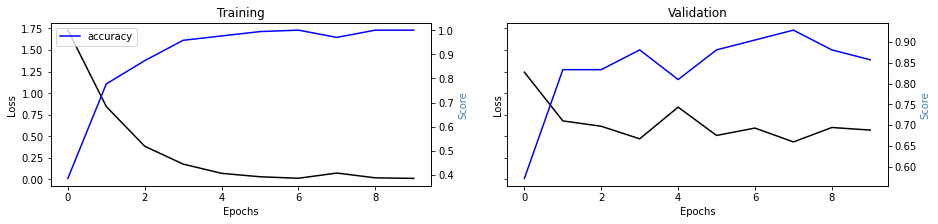

In [ ]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    fold=0
#     conf_matrix_list_of_arrays = []

    k=10
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):

        fold +=1

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model, predicted_prob, predicted = fit_bert_classif(X_train, y_train, X_test, encode_y=True, 
                                                            model=None, epochs=10, batch_size=8)
        # Validade Test Set
        accr = metrics.accuracy_score(y_test, predicted)
        #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays.append(conf_matrix)
        #
        accrs.append(accr)

        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    final_mean.append(sum(accrs)/k)

# means for Confusion Matrix
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

In [ ]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

In [131]:
final_mean

[0.8134615384615385]

### Evaluate

#### Plot Metrics Resume and Confusion Matrix

In [ ]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

## GloVe with Conventional ML

### Create the Feature Vector

In [24]:
class Word2VecVectorizer:
  def __init__(self, word_vect):
    print("Loading in word vectors...")
    self.word_vectors = word_vect
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

### Vetorization

In [25]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(word_vect)
# Get the sentence embeddings for the train and test datasets
X = corpus

y = df["Label"].values

# Use for mNB
from sklearn.preprocessing import MinMaxScaler, normalize
def normalizer(X):
    scaler = MinMaxScaler()
    scaled_X = scaler.fit_transform(X)
    normalized_X = normalize(scaled_X, norm='max', axis=0, copy=True)
    return(normalized_X)

Loading in word vectors...
Finished loading in word vectors


### Cross Validation and Fitting the Model

In [26]:
def encode_y_train(y_train):
    vectorizer = LabelEncoder()
    y_train = vectorizer.fit_transform(y_train)
    return y_train

In [27]:
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y))}

In [38]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    preds = []
    # conf_matrix_list_of_arrays = []
    k = 10
    fold = 0
    
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        fold +=1

        X_train = vectorizer.fit_transform(X_train)
        X_train = normalizer(X_train) # Use for mNB
        X_test = vectorizer.transform(X_test)
        X_test = normalizer(X_test) # Use for mNB

        y_train=encode_y_train(y_train)

        # train classifier
        model = nb.fit(X_train, y_train)


        # test
        predicted_prob = model.predict_proba(X_test)
        predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
                 predicted_prob]
    #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
    #    
        accr = metrics.accuracy_score(y_test, predicted)
        accrs.append(accr)
        preds.append(predicted)    

        print('\n--------------------------------------------------------------------')
        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
        print('--------------------------------------------------------------------')
    final_mean.append(sum(accrs)/k)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

Number of samples with no words found: 0 / 208
Number of samples with no words found: 0 / 52

--------------------------------------------------------------------
Iteração: 1 Fold: 1 Accuracy: 0.5961538461538461, Mean Accuracy: 0.5961538461538461
--------------------------------------------------------------------
Number of samples with no words found: 0 / 208
Number of samples with no words found: 0 / 52

--------------------------------------------------------------------
Iteração: 1 Fold: 2 Accuracy: 0.6923076923076923, Mean Accuracy: 0.6442307692307692
--------------------------------------------------------------------
Number of samples with no words found: 0 / 208
Number of samples with no words found: 0 / 52

--------------------------------------------------------------------
Iteração: 1 Fold: 3 Accuracy: 0.6730769230769231, Mean Accuracy: 0.6538461538461539
--------------------------------------------------------------------
Number of samples with no words found: 0 / 208
Numbe

In [39]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.6903846153846153


### Evaluate

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Design Document     	       0.4	       0.8	      0.53	       0.5	      0.83
List of Contributors	       1.0	      0.86	      0.92	      0.91	      0.93
Setup Files         	      0.67	      0.86	      0.75	      0.71	      0.89
Requirement Document	       0.5	       0.2	      0.29	      0.27	      0.59
License             	       1.0	       1.0	       1.0	       1.0	       1.0
Contributors' Guide 	       0.8	       0.5	      0.62	      0.58	      0.74
Release Notes       	      0.75	      0.75	      0.75	       0.7	      0.85

Micro Average       	      0.73	      0.73	      0.73	      0.71	      0.84
Macro Average       	      0.73	      0.71	      0.69	      0.67	      0.83


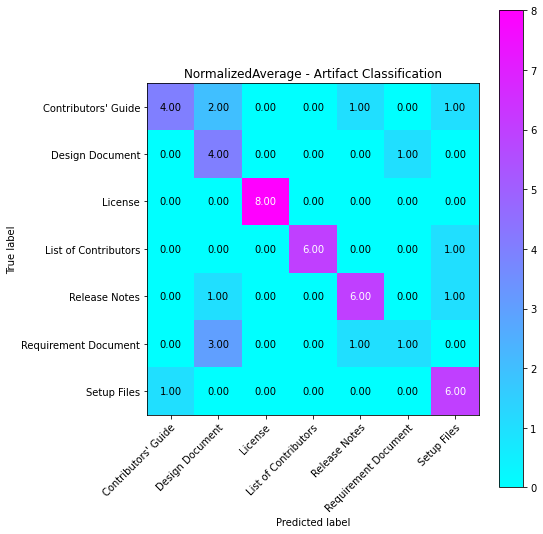

In [41]:
# plot metrics resume
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

### Voting Classifier

In [42]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    # conf_matrix_list_of_arrays = []
    k=10
    fold = 0
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        fold +=1

        X_train = vectorizer.fit_transform(X_train)
        X_train = normalizer(X_train) # Use for mNB
        X_test = vectorizer.transform(X_test)
        X_test = normalizer(X_test) # Use for mNB

        dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}

        model = VotingClassifier(estimators=[
            ('svm', clf1),('rf', clf2), ('mnb', clf3), ('tree', clf4)], voting='hard',weights=[1,1,2,1])
        model = model.fit(X_train, y_train)

        predicted = model.predict(X_test)
        accr = metrics.accuracy_score(y_test, predicted)
        #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
        #    
        accrs.append(accr)
    #     print(metrics.classification_report(y_test, predicted))

        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    final_mean.append(sum(accrs)/k)

# means for Confusion Matrix
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

Number of samples with no words found: 0 / 208
Number of samples with no words found: 0 / 52
Iteração: 1 Fold: 1 Accuracy: 0.75, Mean Accuracy: 0.75
Number of samples with no words found: 0 / 208
Number of samples with no words found: 0 / 52
Iteração: 1 Fold: 2 Accuracy: 0.6538461538461539, Mean Accuracy: 0.7019230769230769
Number of samples with no words found: 0 / 208
Number of samples with no words found: 0 / 52
Iteração: 1 Fold: 3 Accuracy: 0.6730769230769231, Mean Accuracy: 0.6923076923076922
Number of samples with no words found: 0 / 208
Number of samples with no words found: 0 / 52
Iteração: 1 Fold: 4 Accuracy: 0.6730769230769231, Mean Accuracy: 0.6875
Number of samples with no words found: 0 / 208
Number of samples with no words found: 0 / 52
Iteração: 1 Fold: 5 Accuracy: 0.6153846153846154, Mean Accuracy: 0.6730769230769231
Number of samples with no words found: 0 / 208
Number of samples with no words found: 0 / 52
Iteração: 1 Fold: 6 Accuracy: 0.8076923076923077, Mean Accurac

In [43]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.7269230769230769


### Evaluate

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Design Document     	       0.4	       1.0	      0.57	      0.59	      0.93
List of Contributors	       1.0	       1.0	       1.0	       1.0	       1.0
Setup Files         	      0.75	      0.86	       0.8	      0.76	       0.9
Requirement Document	       1.0	       0.2	      0.33	      0.43	       0.6
License             	       1.0	       1.0	       1.0	       1.0	       1.0
Contributors' Guide 	      0.83	      0.62	      0.71	      0.67	       0.8
Release Notes       	      0.86	      0.75	       0.8	      0.76	      0.86

Micro Average       	      0.79	      0.79	      0.79	      0.76	      0.88
Macro Average       	      0.83	      0.78	      0.75	      0.75	      0.87


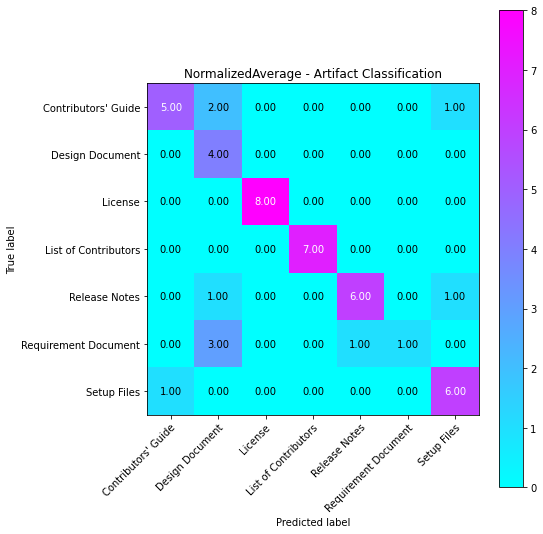

In [45]:
# plot metrics resume
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))